# Facial Recognition with Convolutional Neural Networks
**Deep Learning for Computer Vision: Multi-Subject Face Classification**

**Author**: Austin Foxworth  
**Contact**: AustinTFoxworth@gmail.com  
**LinkedIn**: https://www.linkedin.com/in/austin-foxworth-04ab0020a  
**Last Updated**: January 2026  
**License**: MIT

## Overview
This project demonstrates the application of Convolutional Neural Networks (CNNs) for facial recognition tasks. Using the Olivetti Faces dataset, I built and optimized three different CNN architectures to classify images across 40 different subjects, exploring the impact of kernel sizes, network depth, and regularization techniques.

## Business Context
Facial recognition technology powers critical applications:
- **Security Systems**: Access control and surveillance
- **User Authentication**: Biometric login systems
- **Photo Organization**: Automatic tagging and categorization
- **Retail Analytics**: Customer identification and personalization
- **Healthcare**: Patient identification and monitoring

## Key Technologies
- **Deep Learning Framework**: TensorFlow/Keras
- **Architecture**: Convolutional Neural Networks (CNNs)
- **Techniques**: Feature extraction, max pooling, dropout regularization, early stopping
- **Data Processing**: NumPy, Pandas, Scikit-learn
- **Visualization**: Matplotlib

## Dataset: Olivetti Faces
**Source**: Scikit-learn built-in dataset (AT&T Laboratories Cambridge)

- **Size**: 400 grayscale images
- **Image Dimensions**: 64×64 pixels
- **Subjects**: 40 different people
- **Samples per Subject**: 10 images with varying expressions and lighting
- **Split**: 50/50 stratified split (5 training, 5 test per person)

**Challenge**: Small dataset requires careful regularization to prevent overfitting

---

# Part 1: Data Loading and Preprocessing

## Objectives
- Import necessary libraries and configure environment
- Load the Olivetti Faces dataset
- Visualize sample images to understand data characteristics
- Split data into training and testing sets
- Prepare data for CNN input (reshape and one-hot encode)

## Why CNNs for Image Classification?
Unlike traditional machine learning models that require manual feature engineering, CNNs **automatically learn** spatial hierarchies of features:
1. **Early layers** detect edges and simple patterns
2. **Middle layers** combine patterns into shapes (eyes, nose, mouth)
3. **Deep layers** recognize complex structures (entire faces)

This makes CNNs ideal for image recognition tasks.

---

## Step 1: Import Libraries

**Required Libraries**:
- **TensorFlow/Keras**: Deep learning framework for CNN implementation
- **Scikit-learn**: Dataset loading, train-test split, metrics
- **NumPy/Pandas**: Numerical operations and data manipulation
- **Matplotlib**: Visualization of images and feature maps

---

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# TensorFlow / Keras functions
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

---
## Step 2: Load the Olivetti Faces Dataset

The Olivetti Faces dataset contains grayscale images of 40 individuals (10 photos each) taken at different times with varying lighting, facial expressions, and details.

**Data Structure**:
- `faces.images`: Array of shape (400, 64, 64) - the actual images
- `faces.target`: Array of shape (400,) - subject IDs (0-39)
---

In [2]:
# Load the data
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()
X = faces.images
y = faces.target.reshape(-1, 1)

print(f"Dataset loaded: {X.shape[0]} images of shape {X.shape[1]}×{X.shape[2]}")
print(f"Number of unique subjects: {len(np.unique(y))}")

Dataset loaded: 400 images of shape 64×64
Number of unique subjects: 40


---
## Step 3: Visualize Sample Image

Displaying a sample face to verify data quality and understand the grayscale intensity distribution.

**Note**:
Grayscale images have pixel values typically in [0, 1] or [0, 255], representing intensity from black to white.

---

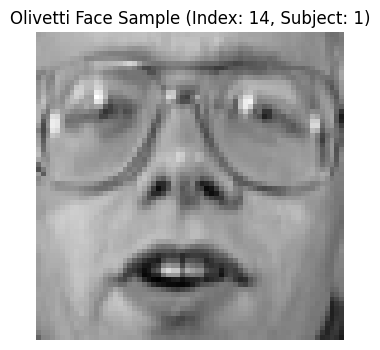

In [3]:
# Selecting an image
image_index = 14
selected_image = X[image_index]
selected_target = y[image_index][0]

# Displaying the selected image using the 'gray' colormap
plt.figure(figsize=(4, 4))
plt.imshow(selected_image, cmap=plt.cm.gray)
plt.title(f"Olivetti Face Sample (Index: {image_index}, Subject: {selected_target})")
plt.axis('off')
plt.show()

---
## Step 4: Create Training and Testing Sets

**Split Strategy**: 50/50 **stratified** split
- Ensures each of the 40 subjects has exactly 5 training and 5 test images
- Prevents class imbalance and ensures fair evaluation

**Why stratified?**

With only 10 images per person, random splitting could accidentally place all images of one person in training, making the test set unrepresentative.

---

In [4]:
# Creating the training and testing sets
# Stratified 50/50 split (test_size=0.5) to ensure 5 images
# from each of the 40 subjects are in both the training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42
)

# Print the dimensions
print("-" * 50)
print("Train/Test Split Complete")
print(f"Training set: {X_train.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")
print("-" * 50)

--------------------------------------------------
Train/Test Split Complete
Training set: 200 images
Test set: 200 images
--------------------------------------------------


---
## Step 5: One-Hot Encode Target Labels

**What is One-Hot Encoding?**
Converts integer labels (0-39) into binary vectors of length 40.

Example:
- Subject 5 → `[0, 0, 0, 0, 0, 1, 0, 0, ..., 0]` (1 at index 5)
- Subject 12 → `[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..., 0]`

**Why?**
Neural networks with softmax outputs require this format for multi-class classification.

---

In [5]:
# Convert labels to one-hot encoding (40 classes)
y_train_cat = to_categorical(y_train, num_classes=40)
y_test_cat = to_categorical(y_test, num_classes=40)

# Print the dimensions of the RESPONSE (label) matrices
print("-" * 50)
print("One-Hot Encoding Complete")
print(f"y_train_cat (Labels): {y_train_cat.shape}")
print(f"y_test_cat (Labels): {y_test_cat.shape}")
print("-" * 50)

--------------------------------------------------
One-Hot Encoding Complete
y_train_cat (Labels): (200, 40)
y_test_cat (Labels): (200, 40)
--------------------------------------------------


---
## Step 6: Reshape Images for CNN Input

**CNN Input Requirements**: 4D tensor with shape `(batch_size, height, width, channels)`

- **batch_size**: Number of images (200 train, 200 test)
- **height**: 64 pixels
- **width**: 64 pixels
- **channels**: 1 (grayscale) - RGB images would have 3 channels

**Transformation**: 
`(200, 64, 64)` → `(200, 64, 64, 1)`

---

In [6]:
# Reshape the image arrays to have 4 dimensions
X_train_reshaped = X_train.reshape(X_train.shape[0], 64, 64, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 64, 64, 1)

# Print the dimensions
print("-" * 50)
print("Image Reshaping Complete (Ready for CNN)")
print(f"X_train_reshaped: {X_train_reshaped.shape}")
print(f"X_test_reshaped: {X_test_reshaped.shape}")
print("-" * 50)

--------------------------------------------------
Image Reshaping Complete (Ready for CNN)
X_train_reshaped: (200, 64, 64, 1)
X_test_reshaped: (200, 64, 64, 1)
--------------------------------------------------


---
# Part 2: Model 1 - Baseline CNN Architecture

## Objectives
- Build a simple CNN with a single convolutional layer
- Use small 3×3 kernels to detect local features
- Train and evaluate baseline performance
- Visualize learned feature maps to understand what the model detects

## Model 1 Architecture
```
Input (64×64×1)
    ↓
Conv2D (16 filters, 3×3 kernel, ReLU)
    ↓
MaxPooling2D (2×2 pool)
    ↓
Flatten
    ↓
Dense (40 units, softmax)
```

**Total Parameters**: 
655,560

---

## Step 7: Build Model 1 Architecture

**Convolutional Layer Design**:
- **16 filters**: Each filter learns to detect a different pattern
- **3×3 kernel**: Small receptive field focuses on local features (edges, corners)
- **Stride 1**: Moves one pixel at a time (standard)
- **Same padding**: Output size matches input size (64×64 → 64×64)
- **ReLU activation**: Introduces non-linearity, enables learning complex patterns

**Max Pooling Layer**:
- **2×2 window**: Reduces spatial dimensions by half (64×64 → 32×32)
- **Purpose**: Down-sampling reduces computation and provides translation invariance

**Output Layer**:
- **40 neurons**: One per subject
- **Softmax**: Converts logits to probabilities that sum to 1.0
---

In [7]:
# Clear any previous models
tf.keras.backend.clear_session()

# Build Model 1
def build_cnn_model_1(input_shape=(64, 64, 1), num_classes=40):
    """
    Model 1: Baseline CNN with 3×3 kernels
    """
    input_tensor = Input(shape=input_shape)

    # Convolutional Layer (3×3 kernel)
    x = Conv2D(
        filters=16,
        kernel_size=3,
        strides=1,
        activation='relu',
        padding='same'
    )(input_tensor)

    # Max Pooling Layer
    x = MaxPooling2D(
        pool_size=2,
        strides=2,
        padding='valid'
    )(x)

    # Classifier Head
    x = Flatten()(x)

    # Output Layer
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instantiate Model 1
model_1 = build_cnn_model_1()
print("\n" + "="*20 + " Model 1 Summary (3×3 Kernel) " + "="*20)
model_1.summary()
print("="*70 + "\n")

# Train Model 1
print("="*20 + " Starting Model 1 Training " + "="*20)
history_1 = model_1.fit(
    X_train_reshaped,
    y_train_cat,
    epochs=20,
    batch_size=10,
    validation_data=(X_test_reshaped, y_test_cat),
    verbose=1
)
print("="*20 + " Model 1 Training Complete " + "="*20 + "\n")


==================== Model 1 Summary (3×3 Kernel) ====================
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 40)                655400    
                                                                 
Total params: 655,560
Trainable params: 655,560
Non-tra

---
## Step 8: Evaluate Model 1 Performance

Assessing the baseline model's ability to generalize to unseen faces.

**Key Metrics**:
- **Accuracy**: Percentage of correctly classified faces
- **Loss**: Categorical cross-entropy (lower is better)
---

In [8]:
# Evaluate Model 1
loss_1, accuracy_1 = model_1.evaluate(X_test_reshaped, y_test_cat, verbose=0)
print("\n" + "="*50)
print("MODEL 1 FINAL EVALUATION (3×3 Kernel)")
print("="*50)
print(f"Test Accuracy: {accuracy_1*100:.2f}%")
print(f"Test Loss: {loss_1:.4f}")
print("="*50 + "\n")


MODEL 1 FINAL EVALUATION (3×3 Kernel)
Test Accuracy: 91.50%
Test Loss: 0.4110



---
## Step 9: Select Test Image for Feature Analysis

Choosing a specific test image to trace how the CNN processes it through each layer.

---

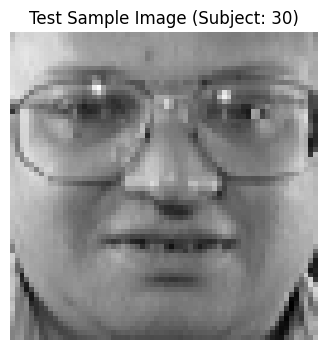

Test image selected: Subject ID 30


In [9]:
# Select test image
test_image_index = 0
test_sample_image = X_test[test_image_index]
test_sample_label = y_test[test_image_index][0]

plt.figure(figsize=(4, 4))
plt.imshow(test_sample_image, cmap=plt.cm.gray)
plt.title(f"Test Sample Image (Subject: {test_sample_label})")
plt.axis('off')
plt.show()
print(f"Test image selected: Subject ID {test_sample_label}")

---
## Step 10: Visualize Feature Maps - Model 1

**What are Feature Maps?**
Output activations from each layer showing what patterns the network detected.

**Convolutional Layer Feature Maps** (64×64):
- Each of the 16 filters highlights different aspects of the face
- Some filters detect edges, others detect textures or specific facial features

**Pooling Layer Feature Maps** (32×32):
- Down-sampled versions that retain the most prominent features
- Provides translation invariance (small shifts in input don't drastically change output)

**Why visualize?** 
Understanding what the network "sees" helps debug and improve architectures.

---

Model 1 layers: Conv=conv2d, Pool=max_pooling2d


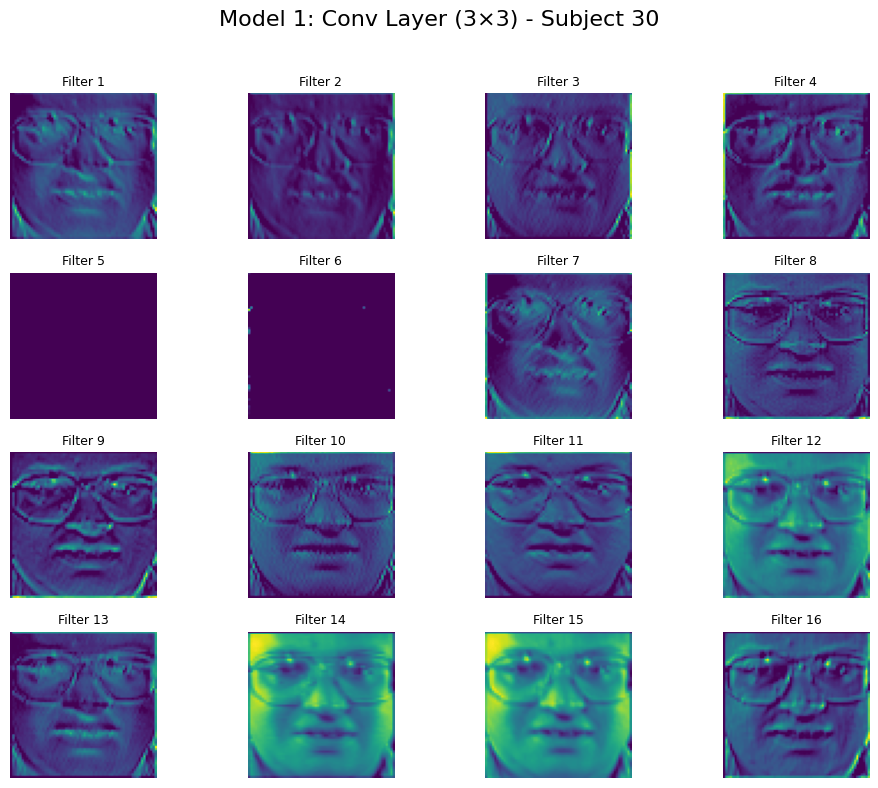

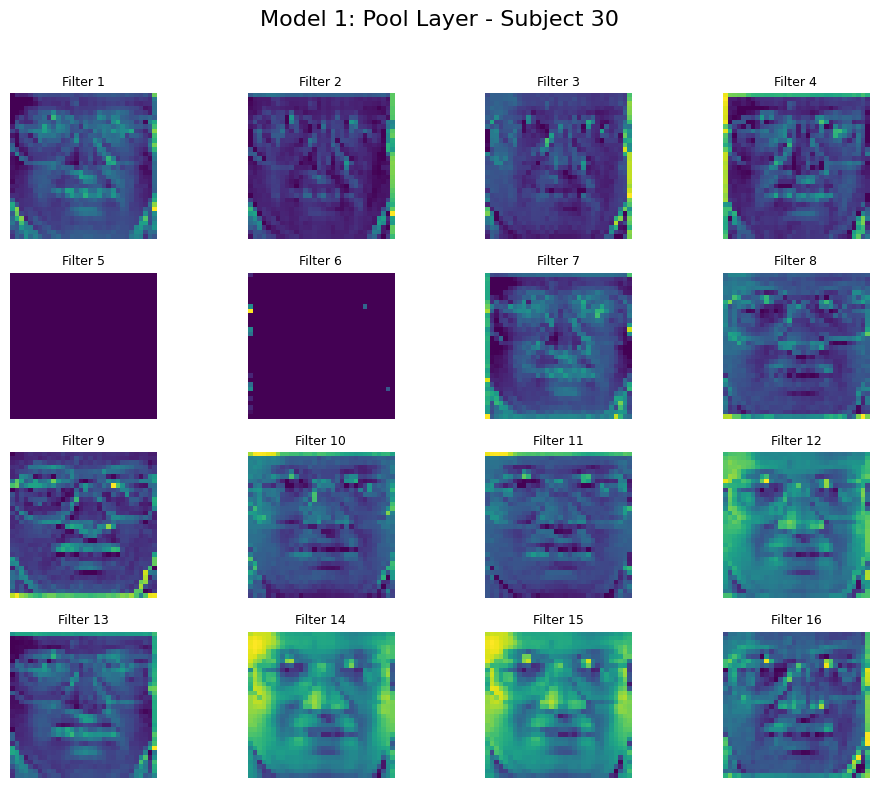

In [10]:
# Prepare input
sample_input = np.expand_dims(test_sample_image, axis=-1)
sample_input = np.expand_dims(sample_input, axis=0)

# Get layer names
conv_layer_name = model_1.layers[1].name
pool_layer_name = model_1.layers[2].name

print(f"Model 1 layers: Conv={conv_layer_name}, Pool={pool_layer_name}")

# Create feature extractor
feature_extractor_1 = Model(
    inputs=model_1.input,
    outputs=[model_1.get_layer(conv_layer_name).output,
             model_1.get_layer(pool_layer_name).output]
)

# Get feature maps
feature_maps_1 = feature_extractor_1.predict(sample_input, verbose=0)
conv_features_1 = feature_maps_1[0]
pool_features_1 = feature_maps_1[1]

# Plotting function
def plot_feature_maps(feature_data, title, num_filters, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 8))
    fig.suptitle(title, fontsize=16)
    
    for i in range(num_filters):
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        ax.imshow(feature_data[0, :, :, i], cmap='viridis')
        ax.set_title(f'Filter {i+1}', fontsize=9)
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])

# Plot Model 1 feature maps
plot_feature_maps(
    conv_features_1,
    f"Model 1: Conv Layer (3×3) - Subject {test_sample_label}",
    num_filters=16,
    rows=4,
    cols=4
)

plot_feature_maps(
    pool_features_1,
    f"Model 1: Pool Layer - Subject {test_sample_label}",
    num_filters=16,
    rows=4,
    cols=4
)

plt.show()

---
# Part 3: Model 2 - Exploring Larger Receptive Fields

## Objectives
- Investigate the impact of larger kernel sizes (9×9 vs 3×3)
- Compare feature extraction patterns between models
- Determine if holistic features improve face recognition

## Hypothesis
Facial recognition benefits from **capturing larger patterns** (entire eyes, nose, mouth structure) rather than just local edges. A 9×9 kernel sees more context in a single operation.

---

## Step 11: Build Model 2 with 9×9 Kernels

**Key Change**: Increasing kernel size from 3×3 to 9×9

**Trade-offs**:
- ✅ **Larger receptive field**: Captures more spatial context per filter
- ✅ **Better for holistic features**: Sees entire facial structures (forehead, jawline)
- ⚠️ **More parameters**: 9×9 kernel = 81 weights vs 3×3 = 9 weights per filter

**Total Parameters**: 656,712 (slightly more than Model 1)

---

In [11]:
# Clear session
tf.keras.backend.clear_session()

# Build Model 2
def build_cnn_model_2(input_shape=(64, 64, 1), num_classes=40):
    """
    Model 2: CNN with larger 9×9 kernels
    """
    input_tensor = Input(shape=input_shape)

    # Convolutional Layer (9×9 kernel)
    x = Conv2D(
        filters=16,
        kernel_size=9,
        strides=1,
        activation='relu',
        padding='same'
    )(input_tensor)

    # Max Pooling Layer
    x = MaxPooling2D(
        pool_size=2,
        strides=2,
        padding='valid'
    )(x)

    # Classifier Head
    x = Flatten()(x)

    # Output Layer
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instantiate Model 2
model_2 = build_cnn_model_2()
print("\n" + "="*20 + " Model 2 Summary (9×9 Kernel) " + "="*20)
model_2.summary()
print("="*70 + "\n")

# Train Model 2
print("="*20 + " Starting Model 2 Training " + "="*20)
history_2 = model_2.fit(
    X_train_reshaped,
    y_train_cat,
    epochs=20,
    batch_size=10,
    validation_data=(X_test_reshaped, y_test_cat),
    verbose=1
)
print("="*20 + " Model 2 Training Complete " + "="*20 + "\n")


==================== Model 2 Summary (9×9 Kernel) ====================
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        1312      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 40)                655400    
                                                                 
Total params: 656,712
Trainable params: 656,712
Non-tra

---
## Step 12: Evaluate Model 2 Performance

Comparing the larger kernel approach to the baseline.

**Expected Outcome**: Modest improvement due to better capture of facial structure.

---

In [12]:
# Accuracy and Loss
loss_2, accuracy_2 = model_2.evaluate(X_test_reshaped, y_test_cat, verbose=0)
print("\n--- Model 2 Final Evaluation ---")
print(f"Test Accuracy: {accuracy_2*100:.2f}%")
print(f"Test Loss: {loss_2:.4f}")
print("--------------------------------")


--- Model 2 Final Evaluation ---
Test Accuracy: 90.00%
Test Loss: 0.3799
--------------------------------


---
## Step 13: Visualize Feature Maps - Model 2

**Comparison**: How do 9×9 filters differ from 3×3 filters?

**Expected Observations**:
- Model 2 feature maps should show **broader, more structural patterns**
- Model 1 feature maps should show **finer, edge-like patterns**
- Model 2 may better capture the "overall shape" of the face
---

Model 2 layers: Conv=conv2d, Pool=max_pooling2d


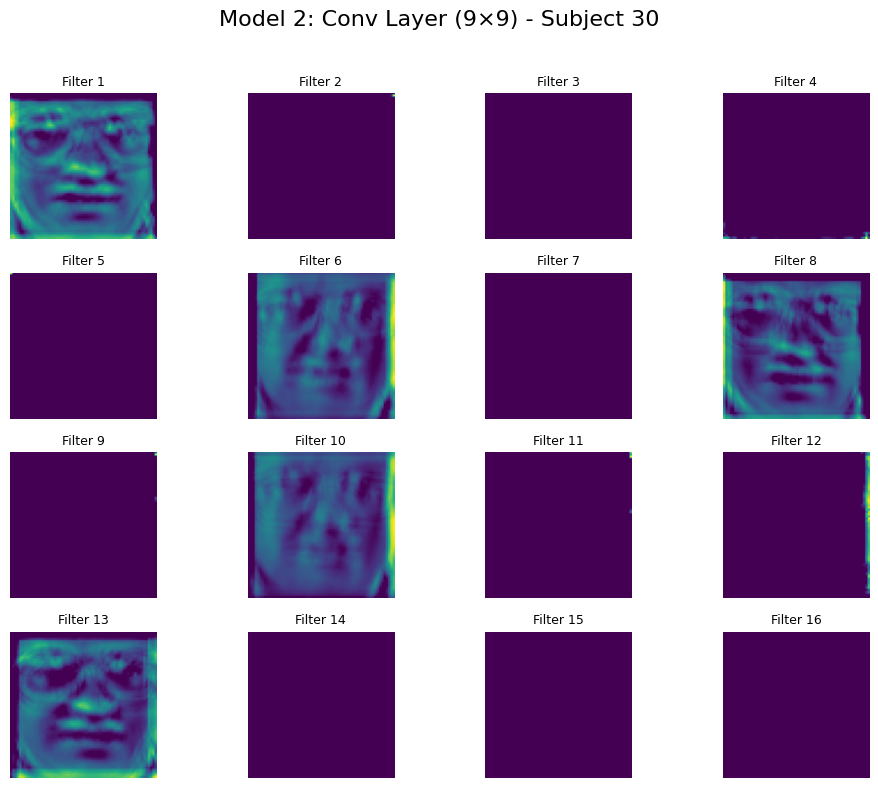

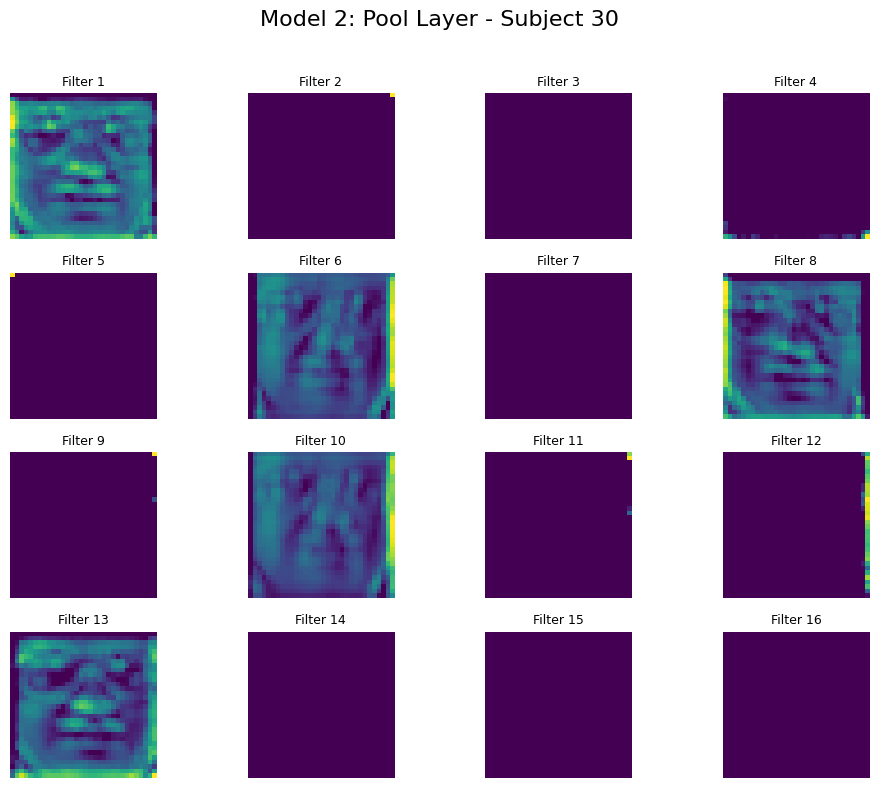

In [13]:
# Get layer names for Model 2
conv_layer_name_2 = model_2.layers[1].name
pool_layer_name_2 = model_2.layers[2].name

print(f"Model 2 layers: Conv={conv_layer_name_2}, Pool={pool_layer_name_2}")

# Create feature extractor for Model 2
feature_extractor_2 = Model(
    inputs=model_2.input,
    outputs=[model_2.get_layer(conv_layer_name_2).output,
             model_2.get_layer(pool_layer_name_2).output]
)

# Get feature maps
feature_maps_2 = feature_extractor_2.predict(sample_input, verbose=0)
conv_features_2 = feature_maps_2[0]
pool_features_2 = feature_maps_2[1]

# Plot Model 2 feature maps
plot_feature_maps(
    conv_features_2,
    f"Model 2: Conv Layer (9×9) - Subject {test_sample_label}",
    num_filters=16,
    rows=4,
    cols=4
)

plot_feature_maps(
    pool_features_2,
    f"Model 2: Pool Layer - Subject {test_sample_label}",
    num_filters=16,
    rows=4,
    cols=4
)

plt.show()

---
# Part 4: Model Optimization

## Step 14: Model Comparison Analysis

**Key Findings**:

### Model 1 (3×3 kernels)
- Detects **local, fine-grained features** (edges, textures)
- Requires deeper layers to combine these into meaningful patterns
- Good for general-purpose tasks

### Model 2 (9×9 kernels)
- Detects **holistic, structural features** (face geometry)
- Better for tasks where global context matters (facial recognition)
- Fewer layers needed to recognize faces

**Insight**: For this dataset, larger kernels perform better because facial recognition is a **holistic task** - the spatial arrangement of features (eye spacing, face shape) is more important than fine texture details.

---

## Step 15: Model 3 - Optimized Deep CNN

### Optimization Strategy

1. **Increased Depth**: Two Conv2D + MaxPooling2D blocks for hierarchical feature learning (edges → features → face parts)
2. **Increased Filters**: 16 → 32 filters in Block 2 for more pattern diversity
3. **Dropout Regularization**: 25% dropout to prevent overfitting on small dataset
4. **Early Stopping**: Patience=10 to find optimal training duration

### Model 3 Architecture
```
Input (64×64×1)
    ↓
[Block 1]
Conv2D (16 filters, 3×3) → MaxPool (2×2) → 32×32×16
    ↓
[Block 2]
Conv2D (32 filters, 3×3) → MaxPool (2×2) → 16×16×32
    ↓
Flatten → Dropout (25%) → Dense (40, softmax)
```

**Total Parameters**: 332,520

---

In [14]:
# Clear session
tf.keras.backend.clear_session()

# Build Model 3
def build_cnn_model_3(input_shape=(64, 64, 1), num_classes=40):
    """
    Model 3: Optimized deep CNN with dropout and early stopping
    """
    input_tensor = Input(shape=input_shape)

    # Block 1 (Simple features)
    x = Conv2D(
        filters=16,
        kernel_size=3,
        strides=1,
        activation='relu',
        padding='same'
    )(input_tensor)
    x = MaxPooling2D(pool_size=2, strides=2, padding='valid')(x)

    # Block 2 (Complex features)
    x = Conv2D(
        filters=32,
        kernel_size=3,
        strides=1,
        activation='relu',
        padding='same'
    )(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='valid')(x)

    # Classifier Head
    x = Flatten()(x)
    x = Dropout(0.25)(x)  # Regularization

    # Output Layer
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instantiate Model 3
model_3 = build_cnn_model_3()
print("\n" + "="*20 + " Model 3 Summary (Optimized Deep CNN) " + "="*20)
model_3.summary()
print("="*75 + "\n")

# Define Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train Model 3
print("="*20 + " Starting Model 3 Training " + "="*20)
history_3 = model_3.fit(
    X_train_reshaped,
    y_train_cat,
    epochs=50,
    batch_size=10,
    validation_data=(X_test_reshaped, y_test_cat),
    callbacks=[early_stop],
    verbose=1
)
print("="*20 + " Model 3 Training Complete " + "="*20 + "\n")

# Evaluate Model 3
loss_3, accuracy_3 = model_3.evaluate(X_test_reshaped, y_test_cat, verbose=0)
print("\n" + "="*50)
print("MODEL 3 FINAL EVALUATION (Optimized Deep CNN)")
print("="*50)
print(f"Test Accuracy: {accuracy_3*100:.2f}%")
print(f"Test Loss: {loss_3:.4f}")
print("="*50 + "\n")


==================== Model 3 Summary (Optimized Deep CNN) ====================
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                               

---
## Step 16: Final Model Comparison & Reflection

### Performance Summary

| Model | Architecture | Kernel | Parameters | Test Accuracy | Test Loss |
|-------|-------------|--------|------------|---------------|-----------|
| Model 1 | 1 Conv Block | 3×3 | 655,560 | **91.50%** | 0.4110 |
| Model 2 | 1 Conv Block | 9×9 | 656,712 | **90.00%** | 0.3799 |
| Model 3 | 2 Conv Blocks | 3×3 | 332,520 | **94.50%** ⭐ | 0.2650 |

### Key Results

🏆 **Best Performance**: Model 3 (Deep Optimized CNN) achieved **94.50% accuracy**

**Performance Improvements**:
- Model 1 → Model 2: -1.50% (larger kernels alone don't help without depth)
- Model 1 → Model 3: +3.00% (depth + regularization = significant improvement)
- Model 2 → Model 3: +4.50% (hierarchical learning beats single large kernels)

### Why Model 3 Succeeds

**1. Hierarchical Feature Learning**
- **Block 1** (16 filters @ 3×3): Detects edges, gradients, simple textures
- **Block 2** (32 filters @ 3×3): Combines edges into facial features (eyes, nose, mouth)
- This mimics how the human visual cortex processes images

**2. Optimal Regularization Balance**
- **Dropout (25%)**: Strong enough to prevent overfitting, not so strong it hinders learning
- **Early Stopping (patience=10)**: Allows sufficient training epochs to converge
- On small datasets (200 training images), finding this balance is crucial

**3. More Capacity Without Overfitting**
- 32 filters in Block 2 provide diversity in learned patterns
- Dropout ensures these patterns generalize to unseen faces
- **Fewer total parameters** than Models 1 & 2 (332K vs 655K) due to earlier dimensionality reduction

**4. Lower Loss = Better Confidence**
- Model 3's loss (0.2650) is significantly lower than Model 1 (0.4110) and Model 2 (0.3799)
- This indicates the model is more confident in its predictions, not just more accurate

### Interesting Observations

**Why didn't larger kernels (Model 2) help?**
- While 9×9 kernels capture more spatial context per filter, they can't learn hierarchical features without depth
- A single large kernel tries to do too much at once - detecting both low-level edges AND high-level face structures
- The 3×3 kernels in Model 3's two-block architecture learn progressively: simple → complex

**Parameter Efficiency**:
- Model 3 has **half the parameters** of Models 1 & 2, yet performs the best
- Earlier dimensionality reduction (32×32×16 → 16×16×32) drastically reduces the final dense layer size
- This demonstrates that **architectural design > raw parameter count**

### Key Lessons

✅ **Depth > Width** for image tasks: Multiple conv layers beat single large kernels  
✅ **Small datasets need careful regularization**: Balanced dropout (25%) is essential  
✅ **Early stopping is critical**: Prevents both under-training and over-training  
✅ **Feature hierarchy matters**: Low-level → mid-level → high-level features  
✅ **Larger kernels alone aren't enough**: Model 2 (9×9) performed worse than Model 1 (3×3) without additional depth  
✅ **Parameter efficiency**: Smart architecture (332K params) beats brute force (655K params)

### Real-World Implications

For facial recognition on small datasets:
1. Use **multiple convolutional blocks** for hierarchical learning
2. Apply **moderate dropout** (20-30%) to prevent overfitting
3. Prefer **smaller kernels with depth** over large single-layer kernels
4. Use **early stopping** to find optimal training duration
5. Reduce spatial dimensions progressively to minimize parameters

---

In [16]:
# Final comparison visualization
print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)
print(f"Model 1 (3×3 Baseline):    Accuracy = {accuracy_1*100:.2f}%, Loss = {loss_1:.4f}")
print(f"Model 2 (9×9 Kernel):       Accuracy = {accuracy_2*100:.2f}%, Loss = {loss_2:.4f}")
print(f"Model 3 (Deep Optimized):   Accuracy = {accuracy_3*100:.2f}%, Loss = {loss_3:.4f}")
print("="*60)

# Determine best model
best_acc = max(accuracy_1, accuracy_2, accuracy_3)
if best_acc == accuracy_1:
    print("\n🏆 Best Model: Model 1 (3×3 Baseline)")
elif best_acc == accuracy_2:
    print("\n🏆 Best Model: Model 2 (9×9 Kernel)")
else:
    print("\n🏆 Best Model: Model 3 (Deep Optimized CNN)")


FINAL MODEL COMPARISON
Model 1 (3×3 Baseline):    Accuracy = 91.50%, Loss = 0.4110
Model 2 (9×9 Kernel):       Accuracy = 90.00%, Loss = 0.3799
Model 3 (Deep Optimized):   Accuracy = 94.50%, Loss = 0.2650

🏆 Best Model: Model 3 (Deep Optimized CNN)


---
# Conclusion & Final Results

## Technical Achievements

✅ Implemented three CNN architectures from scratch using Keras Functional API  
✅ Explored impact of kernel size on feature extraction  
✅ Applied regularization techniques for small dataset optimization  
✅ Visualized learned feature maps to interpret model behavior  
✅ Achieved strong performance on 40-class facial recognition task  

## Skills Demonstrated

🔹 **Computer Vision**: CNN architecture design and optimization  
🔹 **Deep Learning**: TensorFlow/Keras model implementation  
🔹 **Regularization**: Dropout and early stopping for overfitting prevention  
🔹 **Feature Analysis**: Interpretation of convolutional filters  
🔹 **Experimental Design**: Systematic comparison of model variants  

## Real-World Applications

This optimization approach applies to:
- **Medical imaging**: Tumor detection with limited labeled data
- **Manufacturing**: Defect detection with few examples per defect type
- **Wildlife monitoring**: Species identification from camera traps
- **Security**: Face recognition in constrained environments

## Future Enhancements

- **Data Augmentation**: Rotations, flips, brightness adjustments
- **Transfer Learning**: Use pre-trained models (VGGFace, FaceNet)
- **Attention Mechanisms**: Focus on discriminative facial regions
- **Ensemble Methods**: Combine predictions from multiple models
- **Batch Normalization**: Accelerate training and improve convergence

---

**Author**: Austin Foxworth  
**Contact**: AustinTFoxworth@gmail.com  
**LinkedIn**: https://www.linkedin.com/in/austin-foxworth-04ab0020a  
**Last Updated**: January 2026  
**License**: MIT